In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def wrangle(filepath):
    df= pd.read_csv(filepath, sep= ';')
    df.drop(columns= ['sensor_id', 'sensor_type', 'location', 'lat', 'lon'], inplace= True)
    mask_p2= df['value_type'] == 'P2'
    df= df[mask_p2]
    df.drop(columns= ['value_type'], inplace= True)
    
    df['timestamp']= pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace= True)

    #localization
    df.index= df.index.tz_convert('Africa/Nairobi')

    #resampling
    df= df['value'].resample('1h').mean().ffill()

    #df= df.to_frame()
    return df

In [3]:
y= wrangle('data/March_24_sensor_data_archive.csv')
print(type(y))

<class 'pandas.core.series.Series'>


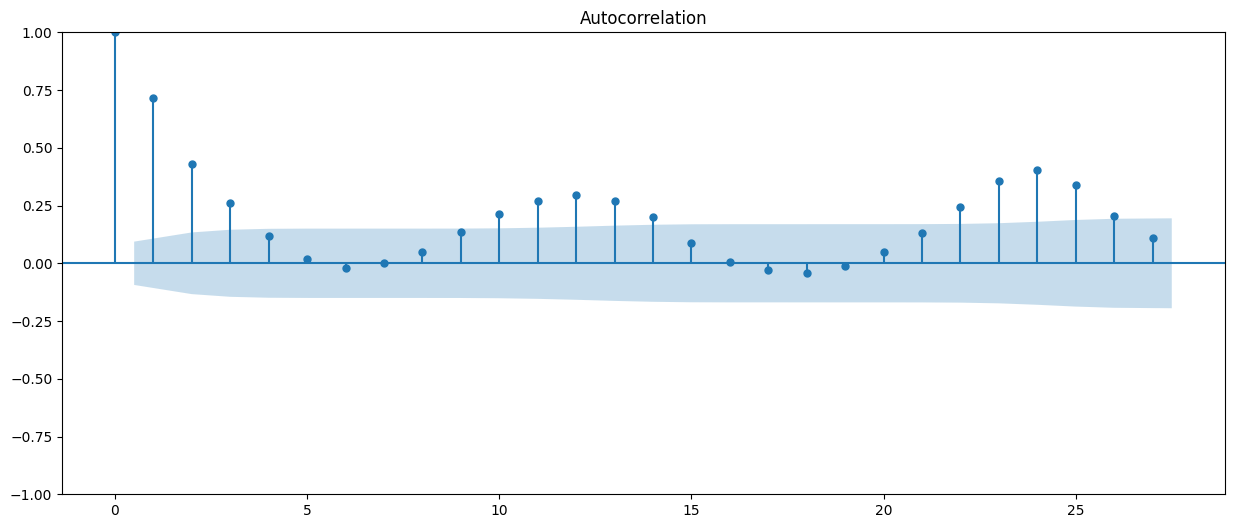

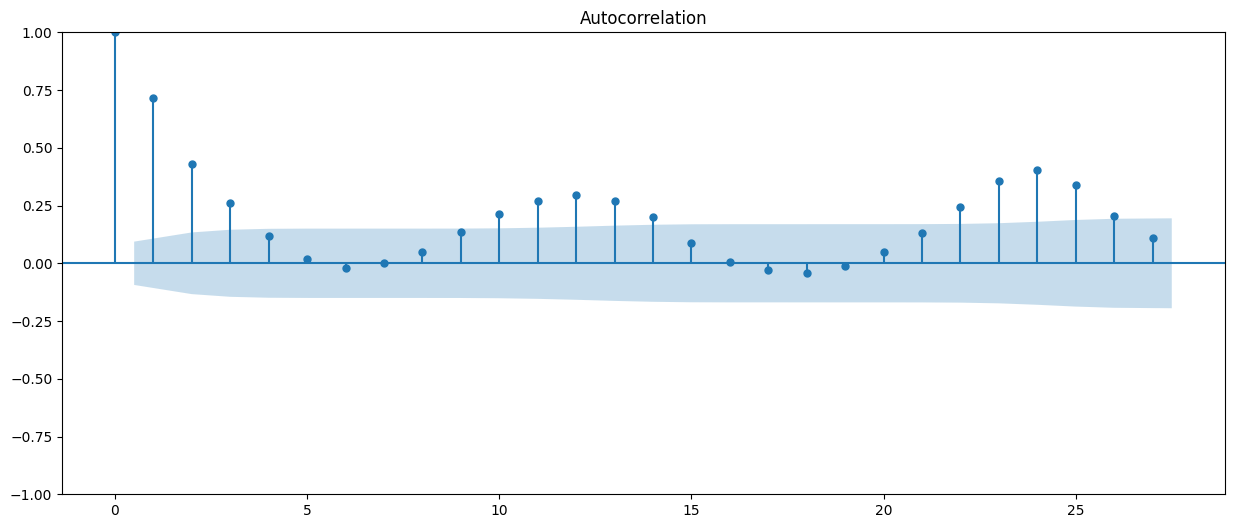

In [4]:
fig, ax= plt.subplots(figsize= (15, 6))
plot_acf(y, ax)

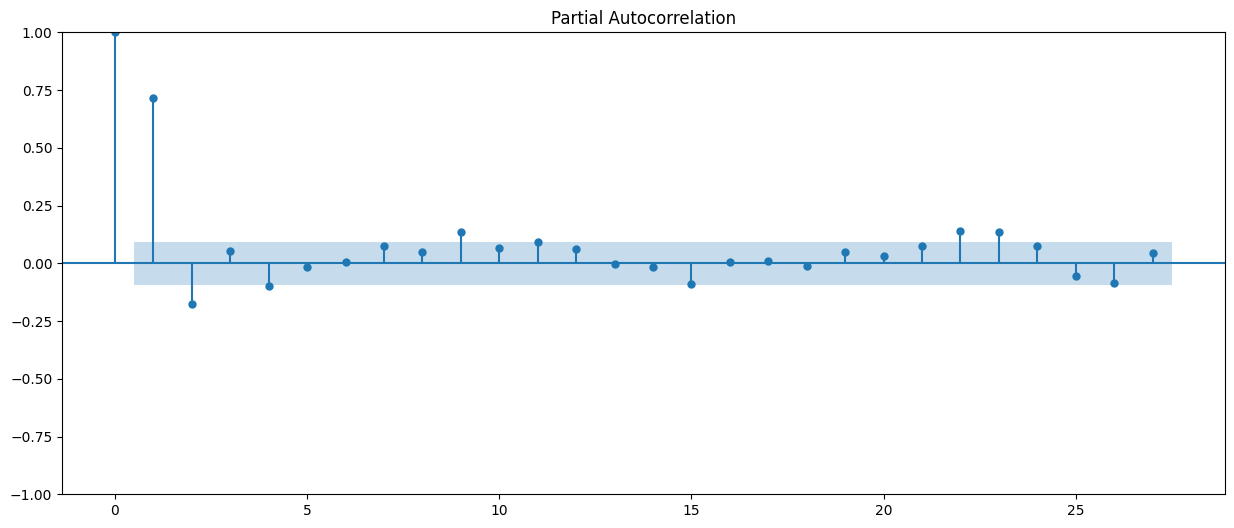

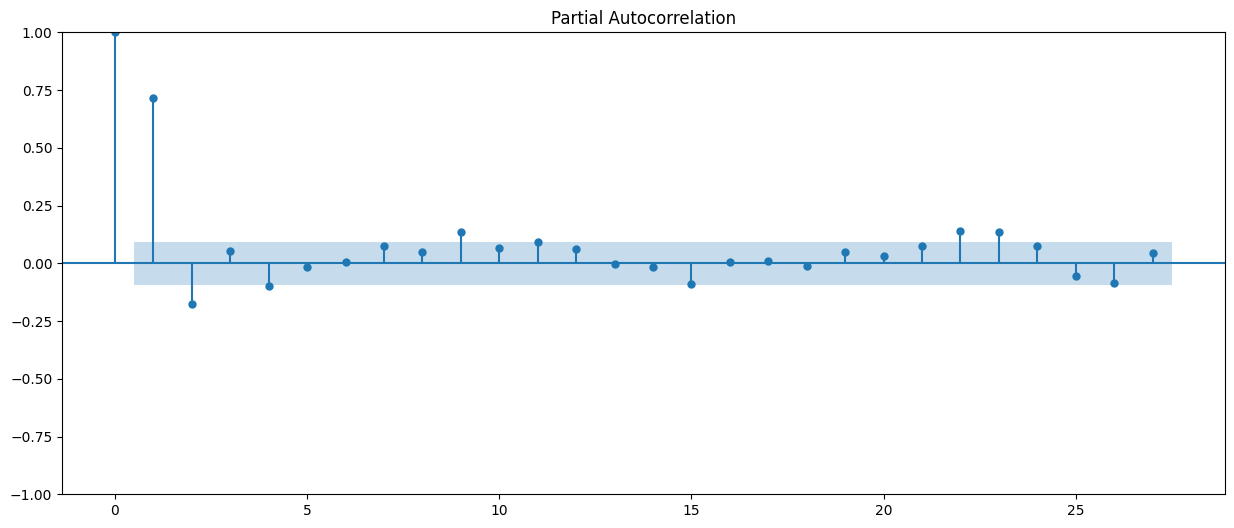

In [5]:
fig, ax= plt.subplots(figsize= (15, 6))
plot_pacf(y, ax)

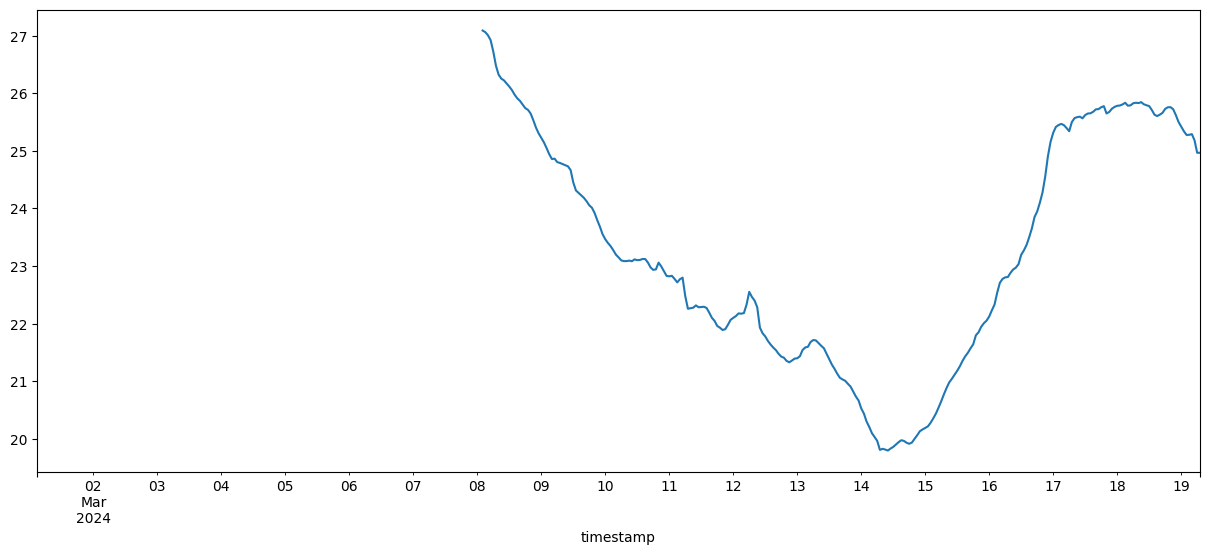

In [6]:
fig, ax= plt.subplots(figsize= (15, 6))
y.rolling(168).mean().plot(ax= ax);

In [7]:
cutoff_test= int(len(y)* 0.95)

y_train= y.iloc[:cutoff_test]
y_test= y.iloc[cutoff_test:]
print(type(y_test))

<class 'pandas.core.series.Series'>


In [8]:
y_mean= y_train.mean()
y_pred_baseline= [y_mean] * len(y_train)
mae_baseline= mean_absolute_error(y_train, y_pred_baseline)
print(f'Mean {y_mean}')
print(f'Baseline mae {mae_baseline}')

Mean 24.991649052444306
Baseline mae 8.689562341030816


In [9]:
#Iteration
model= AutoReg(y_train, lags= 23, old_names= False).fit()

In [10]:
y_pred= model.predict().dropna()

In [11]:
mae_training= mean_absolute_error(y_train.loc[y_pred.index], y_pred)
print('Training MAE:', mae_training)

Training MAE: 4.9751214120607115


<Axes: xlabel='timestamp'>

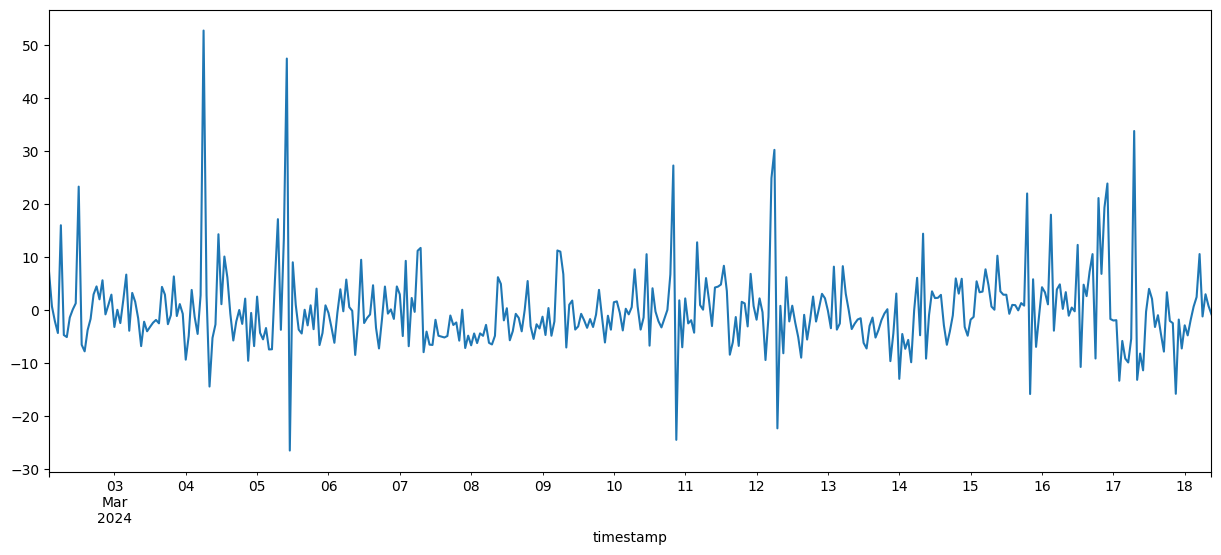

In [12]:
y_train_residual= model.resid
fig, ax= plt.subplots(figsize= (15,6))
y_train_residual.plot(ax= ax)

<Axes: >

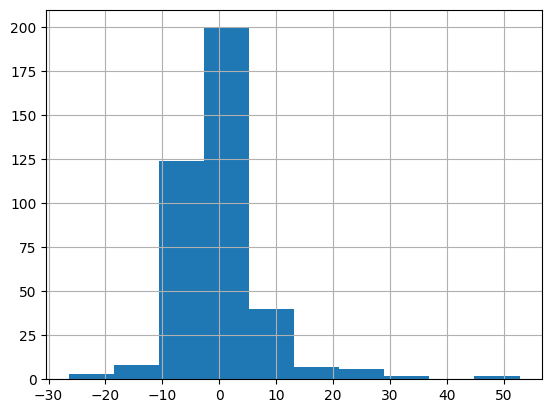

In [13]:
y_train_residual.hist()

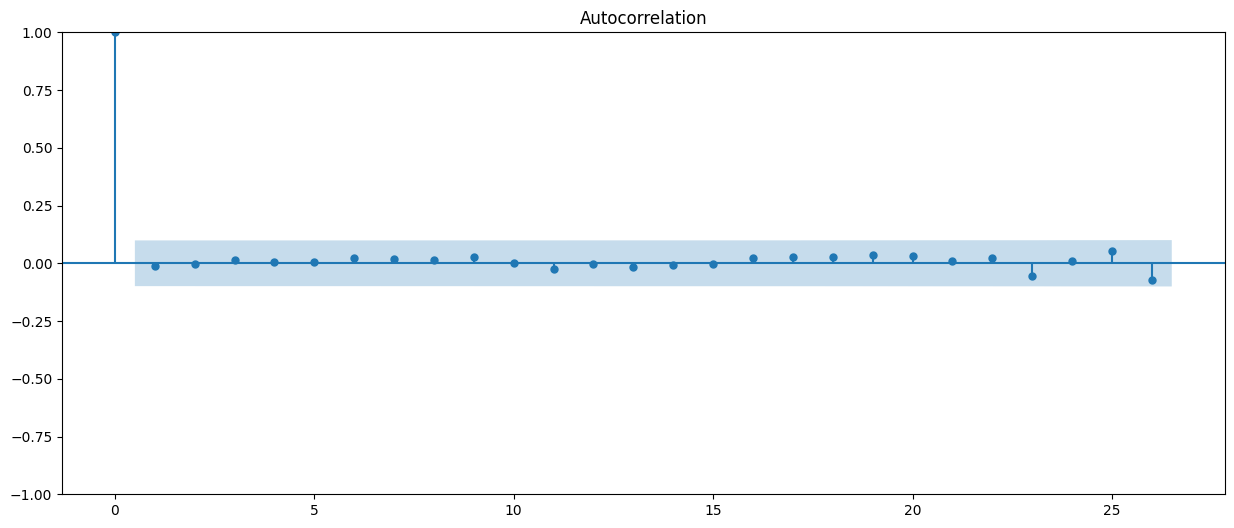

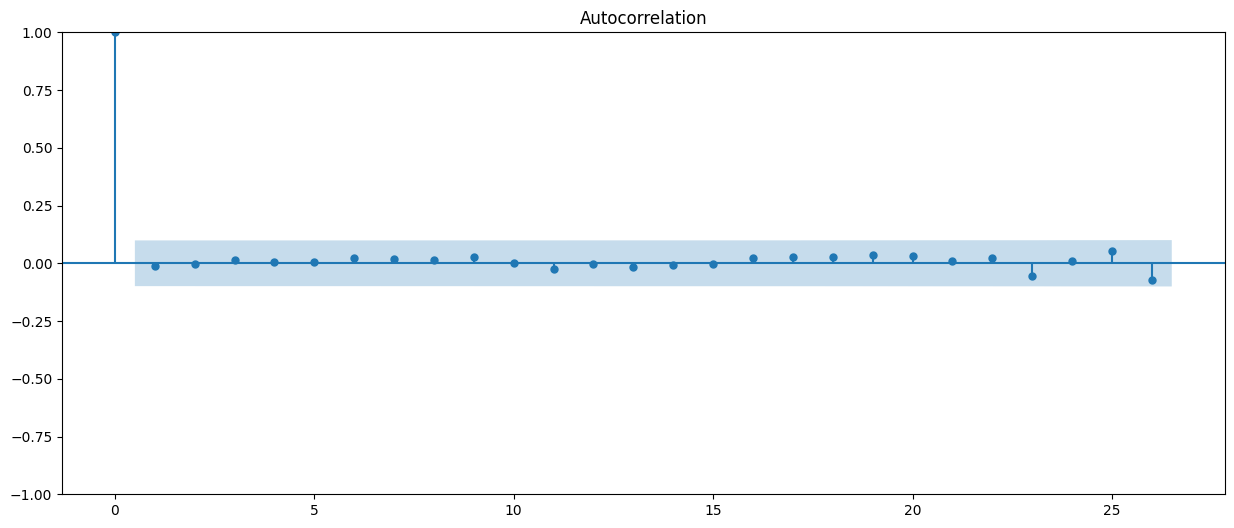

In [14]:
fig, ax= plt.subplots(figsize= (15, 6))
plot_acf(y_train_residual.dropna(), ax=ax)

In [15]:
#Evaluation
y_pred_test= model.predict(y_test.index.min(), y_test.index.max())

In [16]:
test_mae= mean_absolute_error(y_test, y_pred_test)
print('Test MAE', test_mae)

Test MAE 5.708043167159935


In [17]:
test1_predictions= pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_test}, index= y_test.index)
test1_predictions.head()

,y_test,y_pred
timestamp,,
2024-03-18 10:00:00+03:00,23.861613,26.717149
2024-03-18 11:00:00+03:00,25.316409,23.926948
2024-03-18 12:00:00+03:00,25.323915,22.287081
2024-03-18 13:00:00+03:00,23.028981,20.658004
2024-03-18 14:00:00+03:00,19.249242,21.084032


In [18]:
fig= px.line(test1_predictions, labels= {'value': 'P2'})
fig.show()

In [24]:
#wfv
y_pred_wfv= []
history= [x for x in y_train]
for i in range(len(y_test)):
    model= AutoReg(history, lags= 26)
    model_fit= model.fit()
    next_pred= model_fit.forecast()
    y_pred_wfv.append(next_pred[0])
    history.append(y_test.iloc[i])

In [25]:
test_mae= mean_absolute_error(y_test, y_pred_wfv)
print(test_mae)

2.843551484867481


In [26]:
df_pred_tesr= pd.DataFrame({'y_test': y_test, 'y_pred_wfv': y_pred_wfv})
fig= px.line(df_pred_tesr, labels= {'value': 'PM2.5'})
fig.show()